Here we'll show examples of:
- arranging plots on a grid
- Making custom plots
- And some other things

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from utility_programs.read_routines import GITM, SAMI

from utility_programs import filters

import argparse
from tqdm.auto import tqdm
from utility_programs.plot_help import UT_from_Storm_onset
import utility_programs.plotting_routines
import os
import datetime

import geopandas
world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))


In [7]:
import importlib

In [2]:
# test getting figs back from make_map...

In [3]:
gitm_dtimes, gitmgrid, gitmbins, gitmvars = GITM.read_gitm_into_nparrays(
    "/home/axb170054/scratch/GITM-testing/test_folders/step_function_driving/run/data", dtime_storm_start=datetime.datetime(2011,5,21,13,40), t_start_idx=1, t_end_idx=1,return_vars=True)

  0%|          | 0/24 [00:00<?, ?it/s]

In [4]:
gitmbins.shape

(24, 37, 90, 180, 50)

In [63]:
pr = importlib.reload(utility_programs.plotting_routines)

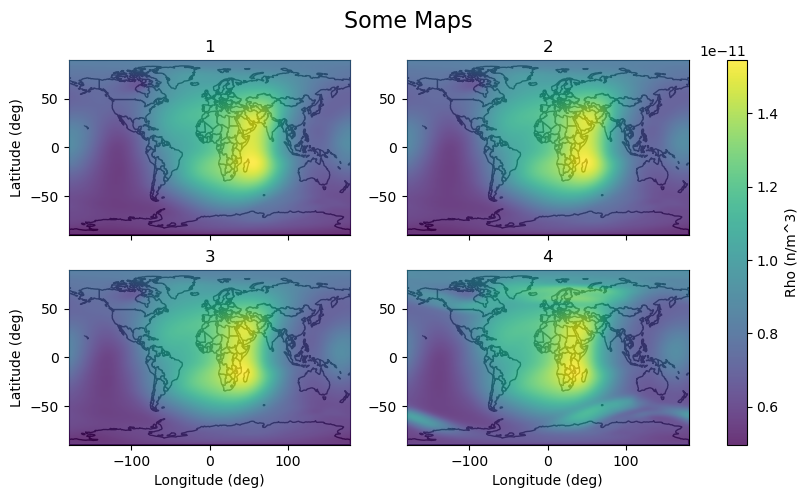

In [113]:
nrows = 2
ncols = 2


data=[[0,0],[0,0]]
data[0][0] = gitmbins[0,0,:,:,30]
data[0][1] = gitmbins[5,0,:,:,30]
data[1][0] = gitmbins[10,0,:,:,30]
data[1][1] = gitmbins[15,0,:,:,30]

titles=[[0,0],[0,0]]
titles[0][0] = "1"
titles[0][1] = "2"
titles[1][0] = "3"
titles[1][1] = "4"

fig, axes = plt.subplots(nrows,ncols, figsize=(10,5), sharex=True)

for row in range(nrows):
    for col in range(ncols):
        im = pr.draw_map(data[row][col], [np.min(data1), np.max(data1)], save_or_show="return", ax=axes[row,col], title=str(row))
        
        axes[row,col].set_title(titles[row][col])
        
        if col == 0:
            axes[row,col].set_ylabel("Latitude (deg)")
        if row == nrows-1:
            axes[row,col].set_xlabel("Longitude (deg)")


fig.suptitle('Some Maps          ', fontsize=16, ha='center')
# spaces needed to center properly with the colorbar existing.
    
fig.colorbar(im, ax=axes.ravel().tolist(), orientation="vertical",
             label = 'Rho (n/m^3)')
fig.align_xlabels()


plt.show()
plt.close()

## Panel of Joule Heating & Particle Heating 10 mins after storm onset.

NameError: name 'lats' is not defined

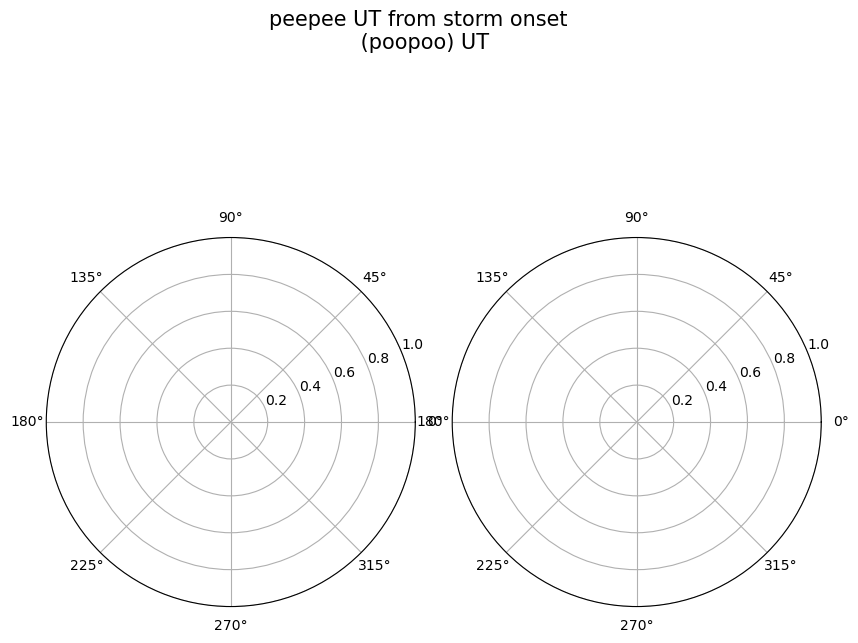

In [100]:
fig = plt.figure(figsize=(10, 8.5))

fig.suptitle('%s UT from storm onset \n (%s) UT'
                % (UT_from_Storm_onset(
                    dtime, dtime_storm_start),
                str(dtime)), fontsize=15)

gs1 = GridSpec(nrows=2, ncols=2, wspace=.1, hspace=.1)
ax0 = fig.add_subplot(gs1[0, 0], projection='polar')
ax1 = fig.add_subplot(gs1[0, 1], projection='polar')
ax2 = fig.add_subplot(gs1[1, :2])

# add in plots. polar left, polar right, map
r, theta = np.meshgrid(90-lats[maskNorth], lons)
ax0.pcolor(np.deg2rad(theta), r,
            poldata[p_fig][nt, :, maskNorth].T.copy(),
            vmin=np.min(poldata[p_fig]),
            vmax=np.max(poldata[p_fig]))
ylabels = ['80', '70', '60', '50']
ax0.set_yticklabels(ylabels)
ax0.set_xticks(np.arange(0, 2*np.pi, np.pi/2))
ax0.set_yticks(np.arange(10, 50, 10))
ax0.set_title('North')

r, theta = np.meshgrid(lats[maskSouth], lons)
cb = ax1.pcolor(np.deg2rad(theta), r,
                poldata[p_fig][nt, :, maskSouth].T.copy(),
                vmin=minP[p_fig], vmax=maxP[p_fig])
ylabels = ['-80', '-70', '-60', '-50']
ax1.set_yticklabels(ylabels)
ax1.set_title('South')
fig.colorbar(cb, ax=ax1,
                label=p_fig + ' ' + args.polar_var)